In [1]:
import pandas as pd
import numpy  as np

import pickle
 
from pathlib import Path

from scipy.stats import  mannwhitneyu, ks_2samp

import matplotlib.pyplot as plt


import sys
sys.path.append("D:/analyze_Pearson_residuals")

from  plot_tab_utilities import *



pd.set_option('display.max_columns', 5)

In [2]:
#### user specified
data_folder = r"D:/analyze_Pearson_residuals/"

data_subfolder = "Macosko_GEO"

data_path = Path ( data_folder + data_subfolder )

In [3]:
# output plots
Ag_plot_jpg = data_subfolder + "_Figure_2.jpg"
Lg_plot_jpg = data_subfolder + "_Figure_4.jpg"  
Sg_plot_jpg = data_subfolder + "_Figure_6.jpg"


# input data
nru_dict_pkl =  "nru_dict.pkl"
scanpy_variance_pkl = "residual_variance_scanpy.pkl"
SCT_variance_pkl = "SCT_v2_residual_variance.pkl"
Ag_complementary_pkl = "Ag_complementary_samples.pkl"
Lg_complementary_pkl = "Lg_complementary_samples.pkl"
Sg_complementary_pkl = "Sg_complementary_samples.pkl"
 


# paths: output plots
Ag_plot_dsn = data_path / Ag_plot_jpg
Lg_plot_dsn = data_path / Lg_plot_jpg
Sg_plot_dsn = data_path / Sg_plot_jpg

# paths: input data
nru_dict_dsn = data_path / nru_dict_pkl
scanpy_variance_dsn = data_path / scanpy_variance_pkl
SCT_variance_dsn = data_path / SCT_variance_pkl
Ag_complementary_dsn = data_path / Ag_complementary_pkl
Lg_complementary_dsn = data_path / Lg_complementary_pkl
Sg_complementary_dsn = data_path / Sg_complementary_pkl

In [4]:
def plot_tab ( df_analy, method_symbol, method_label, plot_jpg_dsn ):

  df_analy['ratio'] = df_analy[1]/ df_analy[0]
  df_analy['abs_log_ratio'] = np.abs ( np.log10 ( df_analy['ratio'] ) ) 

  df_analy['rank_0'] = df_analy[0].rank ( ascending=False )
  df_analy['rank_1'] = df_analy[1].rank ( ascending=False )

  df_analy['group_0'] = pd.cut ( df_analy['rank_0'], bins, labels=labels )
  df_analy['group_1']   = pd.cut ( df_analy['rank_1'], bins, labels=labels )
 
  xtab_in = df_analy.rename( columns={'group_0':'S', 'group_1':'S_tilde'} )
  pt_S_v_S_tilde = pv_table_noprint_margins ( xtab_in, 'S', 'S_tilde' )


  df_top_2K = df_analy[ df_analy['rank_stat'] <= 2000 ]     
  x_cut = pd.qcut ( df_top_2K['nz_cells'].values, 4, labels=['Q1','Q2', 'Q3', 'Q4'], retbins=True )  
  y_cut = pd.qcut ( df_top_2K['abs_log_ratio'].values, 4, labels=['Q1','Q2', 'Q3', 'Q4'], retbins=True )  
  df_top_2K = df_top_2K.assign( Q_nz_cells = x_cut[0] )  
  df_top_2K = df_top_2K.assign( Q_instability = y_cut[0] )    
  pt = pv_table_noprint_margins ( df_top_2K, 'Q_instability', 'Q_nz_cells' )  
  pt_instability_v_nz_cells = ( pt.transpose() [[ 'Q4','Q3','Q2','Q1', 'Total']] ).transpose()
    
    
  rank_stat_200 = df_analy['stat'].loc [ df_analy['rank_stat'] <= 200 ].min()  
  print (  '\n\n genes rank_stat_200: ', rank_stat_200 )  

 
  fig, (ax1, ax2, ax3 )  = plt.subplots(1,3, figsize=( 8., 3. ) )

  plot_ax ( df_analy, ax1, 'A', 0, 1, 'sample S', 'sample $\~S$'  )
    
  plot_ax ( df_analy, ax2, 'B', 'stat', 'abs_log_ratio', method_label,  method_symbol.lower()  + ': instability' , yscale_log=False, line_slope='none' )
  ax2.axvline ( rank_stat_200,  linewidth=1, color='red') 

  plot_ax ( df_analy, ax3, 'C', 'nz_cells', 'abs_log_ratio',  "$n_g$: nonzero cells" , method_symbol.lower()  + ': instability' ,yscale_log=False, line_slope='none' )
  

  y_min2, y_max2 = ax2.get_ylim()
  y_min3, y_max3 = ax3.get_ylim()
  y_min = min ( y_min2, y_min3 )
  y_max = max ( y_max2, y_max3 )
  ax2.set_ylim ( y_min, y_max )
  ax3.set_ylim ( y_min, y_max )    
  

  plt.subplots_adjust( wspace=0.3, bottom=0.2 )
  plt.savefig(  plot_jpg_dsn, transparent=True, dpi=300 )  
    
  return ( pt_S_v_S_tilde, pt_instability_v_nz_cells,  df_top_2K['abs_log_ratio'].values )

In [5]:
pctl_list = [.01,.05, .10, .25, .5, .75, .90, .95, .99 ]


bins = [ 0, 20, 50, 100, 200, 500, 2000, 1e6]
labels = ['1-20', '21-50', '51-100', '101-200', '201-500','501-2000', '2001+']

In [6]:
f = open( nru_dict_dsn, 'rb' )    
nru_dict = pickle.load(f)           
f.close()       


df_nz_cells = nru_dict['df_gene_stats'] [['nz_cells']]
print (  '\n\n df_nz_cells: ' )  
print (  '\n', df_nz_cells   )  


df_A_g = nru_dict['df_gene_stats'] [['A_g']].rename( columns={'A_g':'stat'} )
df_A_g['rank_stat'] = df_A_g['stat'].rank( ascending=False )
print ( '\n\n df_A_g:  ' )
print ( '\n', df_A_g )

 
df_L_g = pd.read_pickle ( scanpy_variance_dsn )[['CLIPPED']].rename( columns={'CLIPPED':'stat'} )
df_L_g['rank_stat'] = df_L_g['stat'].rank( ascending=False )
print ( '\n\n df_L_g:  ' )
print ( '\n', df_L_g )


df_S_g = pd.read_pickle ( SCT_variance_dsn ).rename( columns={'residual_variance':'stat'} )
df_S_g['rank_stat'] = df_S_g['stat'].rank( ascending=False )
print ( '\n\n df_S_g:  ' )
print ( '\n', df_S_g )



 df_nz_cells: 

                nz_cells
CARTPT              812
RGS5                417
RHO               21812
APOE               2255
GLUL               4792
...                 ...
RTN4R                55
GM25749              60
KIF26B               51
A330033J07RIK        61
RHOV                 51

[13552 rows x 1 columns]


 df_A_g:  

                     stat  rank_stat
CARTPT         42.740254        1.0
RGS5           17.483289        2.0
RHO            15.539177        3.0
APOE           14.865133        4.0
GLUL           14.769975        5.0
...                  ...        ...
RTN4R           0.337634    13547.5
GM25749         0.337634    13547.5
KIF26B          0.337634    13547.5
A330033J07RIK   0.337634    13547.5
RHOV            0.337634    13547.5

[13552 rows x 2 columns]


 df_L_g:  

                     stat  rank_stat
CARTPT         44.270155        1.0
RGS5           20.431153        2.0
RHO            12.699057        8.0
APOE           16.193743        4.0


  A_g


 df_complementary_stats_Ag

                 0          1
CARTPT  42.555279  34.216827
RGS5    18.789861  13.142684
APOE    15.425091  13.912950
RHO     14.919805  15.568703
GLUL    14.640142  14.538062
...           ...        ...
KCNQ3    0.469762   0.563198
EFNA5    0.469762   0.456927
BTBD11   0.469762   0.507167
CCNE1    0.469762   0.550283
MRAP2    0.469762   0.456733

[12082 rows x 2 columns]


 genes rank_stat_200:  2.2220673592554827


 Table 3

 S_tilde   1-20  21-50  51-100  101-200  201-500  501-2000  2001+  Total
S                                                                      
1-20        18      2       0        0        0         0      0     20
21-50        2     25       3        0        0         0      0     30
51-100       0      3      42        5        0         0      0     50
101-200      0      0       5       81       12         1      1    100
201-500      0      0       0       14      224        61      1    300
501-2000     0      0      

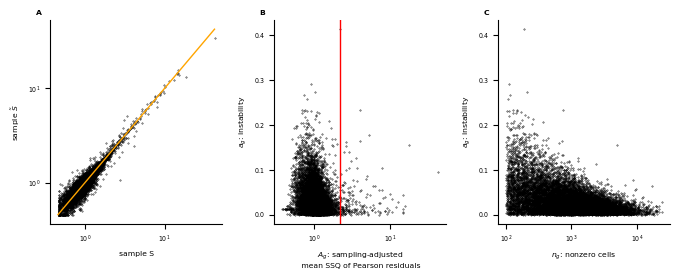

In [7]:
print ( '\n  A_g' )  
df_complementary_stats_Ag = pd.read_pickle ( Ag_complementary_dsn )  
print ( '\n\n df_complementary_stats_Ag' )
print ( '\n', df_complementary_stats_Ag )  

df_stats_Ag = pd.concat ( [ df_nz_cells, df_A_g ], axis=1 ) 
df_stats_Ag = df_stats_Ag.merge ( df_complementary_stats_Ag, how='inner', left_index=True, right_index=True )
pt_S_v_S_tilde, pt_instability_v_nz_cells, arr_instability_Ag = plot_tab ( df_stats_Ag, "$A_g$", '$A_g$: sampling-adjusted \n mean SSQ of Pearson residuals',  Ag_plot_dsn )  

print ( '\n\n Table 3' )
pd.set_option('display.max_columns', 8)
print ( '\n', pt_S_v_S_tilde )  
pd.set_option('display.max_columns', 5)
print ( '\n\n Table 4' )
print ( '\n', pt_instability_v_nz_cells ) 


  L_g


 df_complementary_stats_Lg

                    0          1
CARTPT     34.868703  28.818525
RGS5       21.454272  16.127682
APOE       17.131418  15.826166
GLUL       15.464545  14.996507
MT-RNR2    14.496866  13.857703
...              ...        ...
IL34        0.501279   0.455905
SLC41A3     0.499102   0.690357
FABP3-PS1   0.489785   0.475354
SHB         0.486703   0.570099
GM26906     0.469195   0.619259

[12082 rows x 2 columns]


 genes rank_stat_200:  2.519073816502952


 Table 6

 S_tilde   1-20  21-50  51-100  101-200  201-500  501-2000  2001+  Total
S                                                                      
1-20        19      1       0        0        0         0      0     20
21-50        1     27       2        0        0         0      0     30
51-100       0      2      40        7        1         0      0     50
101-200      0      0       6       78       14         2      0    100
201-500      0      0       2       14      209        60     15

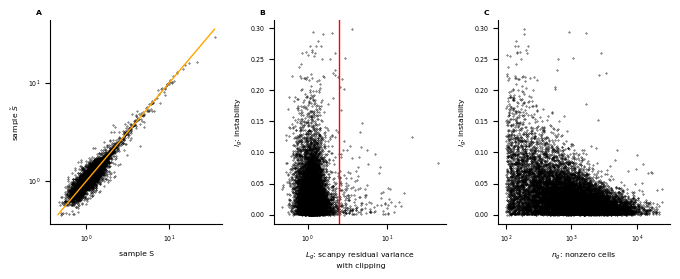

In [8]:
print ( '\n  L_g' )  
df_complementary_stats_Lg = pd.read_pickle ( Lg_complementary_dsn )  
print ( '\n\n df_complementary_stats_Lg' )
print ( '\n', df_complementary_stats_Lg )  

df_stats_Lg = pd.concat ( [ df_nz_cells, df_L_g ], axis=1 ) 
df_stats_Lg = df_stats_Lg.merge ( df_complementary_stats_Lg, how='inner', left_index=True, right_index=True )
pt_S_v_S_tilde, pt_instability_v_nz_cells, arr_instability_Lg = plot_tab ( df_stats_Lg,  "$L_g$", '$L_g$: scanpy residual variance \n with clipping', Lg_plot_dsn ) 

print ( '\n\n Table 6' )
pd.set_option('display.max_columns', 8)
print ( '\n', pt_S_v_S_tilde )  
pd.set_option('display.max_columns', 5)
print ( '\n\n Table 7' )
print ( '\n', pt_instability_v_nz_cells ) 


  S_g


 df_complementary_stats_Sg

                       0         1
gene_vector                      
0610007N19RIK  0.241094  0.221250
0610007P14RIK  0.883185  0.825244
0610009B22RIK  1.083600  1.076853
0610009D07RIK  0.882407  0.821319
0610009E02RIK  0.188780  0.234825
...                 ...       ...
ZXDC           0.528365  0.514447
ZYG11B         1.089829  1.007962
ZYX            0.475080  0.480503
ZZEF1          0.920939  0.867850
ZZZ3           1.165178  1.187622

[12082 rows x 2 columns]


 genes rank_stat_200:  1.9724923113202861


 Table 9

 S_tilde   1-20  21-50  51-100  101-200  201-500  501-2000  2001+  Total
S                                                                      
1-20        20      0       0        0        0         0      0     20
21-50        0     28       1        0        1         0      0     30
51-100       0      2      40        8        0         0      0     50
101-200      0      0       9       73       14         2      2    100
201-5

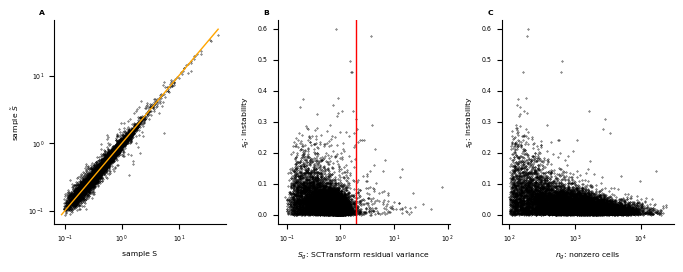

In [9]:
print ( '\n  S_g' )  
df_complementary_stats_Sg = pd.read_pickle ( Sg_complementary_dsn ).set_index ( ['gene_vector'] ).rename( columns={'0':0, '1':1 } )
print ( '\n\n df_complementary_stats_Sg' )
print ( '\n', df_complementary_stats_Sg ) 
 
df_stats_Sg = pd.concat ( [ df_nz_cells, df_S_g ], axis=1 ) 
df_stats_Sg = df_stats_Sg.merge ( df_complementary_stats_Sg, how='inner', left_index=True, right_index=True )
pt_S_v_S_tilde, pt_instability_v_nz_cells, arr_instability_Sg = plot_tab ( df_stats_Sg,  "$S_g$" , '$S_g$: SCTransform residual variance', Sg_plot_dsn ) 

print ( '\n\n Table 9' )
pd.set_option('display.max_columns', 8)
print ( '\n', pt_S_v_S_tilde )  
pd.set_option('display.max_columns', 5)
print ( '\n\n Table 10' )
print ( '\n', pt_instability_v_nz_cells ) 

In [10]:
MW_stat, MW_pv = mannwhitneyu( arr_instability_Lg, arr_instability_Ag, alternative='greater' )  
KS_stat, KS_pv = ks_2samp( arr_instability_Lg, arr_instability_Ag, alternative='less' )   

print ( ' one-sided tests \n ---------------  \n\n null: L_g = A_g,  alternative: L_g > A_g' )
print ( '\n scipy.stats.mannwhitneyu: \n statistic = ', MW_stat,'     p = ', MW_pv )
print ( '\n scipy.stats.ks_2samp:  \n statistic = ', MW_stat,'     p = ', KS_pv )


MW_stat, MW_pv = mannwhitneyu( arr_instability_Sg, arr_instability_Ag, alternative='greater' )  
KS_stat, KS_pv = ks_2samp( arr_instability_Sg, arr_instability_Ag, alternative='less' )   

print ( '\n\n null: S_g = A_g,  alternative: S_g > A_g' )
print ( '\n scipy.stats.mannwhitneyu: \n statistic = ', MW_stat,'     p = ', MW_pv )
print ( '\n scipy.stats.ks_2samp:  \n statistic = ', MW_stat,'     p = ', KS_pv )

 one-sided tests 
 ---------------  

 null: L_g = A_g,  alternative: L_g > A_g

 scipy.stats.mannwhitneyu: 
 statistic =  1903270.0      p =  0.008245690815000161

 scipy.stats.ks_2samp:  
 statistic =  1903270.0      p =  0.0008169810956179924


 null: S_g = A_g,  alternative: S_g > A_g

 scipy.stats.mannwhitneyu: 
 statistic =  2018891.0      p =  0.024325893047699373

 scipy.stats.ks_2samp:  
 statistic =  2018891.0      p =  0.05022159030670728
